In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay, RocCurveDisplay

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [66]:
df = pd.read_csv("https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/Employee_Attrition_Data_Set.csv")

In [67]:
df.head()

,Employee ID,Age,Gender,Job Role,Department,Monthly Income,Years at Company,Number of Promotions,Last Raise Percentage,Distance from Office,Job Satisfaction,Performance Rating,Attrition
0,1,50,Male,HR,IT,11547,12,1,12.288783,41.307654,9,1,No
1,2,36,Male,Sales,Support,8643,28,4,3.496371,44.733204,8,1,Yes
2,3,29,Male,Technician,HR,12418,12,4,4.796945,18.646876,1,3,No
3,4,42,Male,Technician,Support,11441,25,1,10.310471,15.790848,8,4,No
4,5,40,Female,Engineer,Sales,9178,25,2,6.210127,41.239179,6,4,No


### data clean


In [68]:
data=df
missing_values = data.isnull().sum()
print(missing_values)

Employee ID              0
Age                      0
Gender                   0
Job Role                 0
Department               0
Monthly Income           0
Years at Company         0
Number of Promotions     0
Last Raise Percentage    0
Distance from Office     0
Job Satisfaction         0
Performance Rating       0
Attrition                0
dtype: int64


### EDA

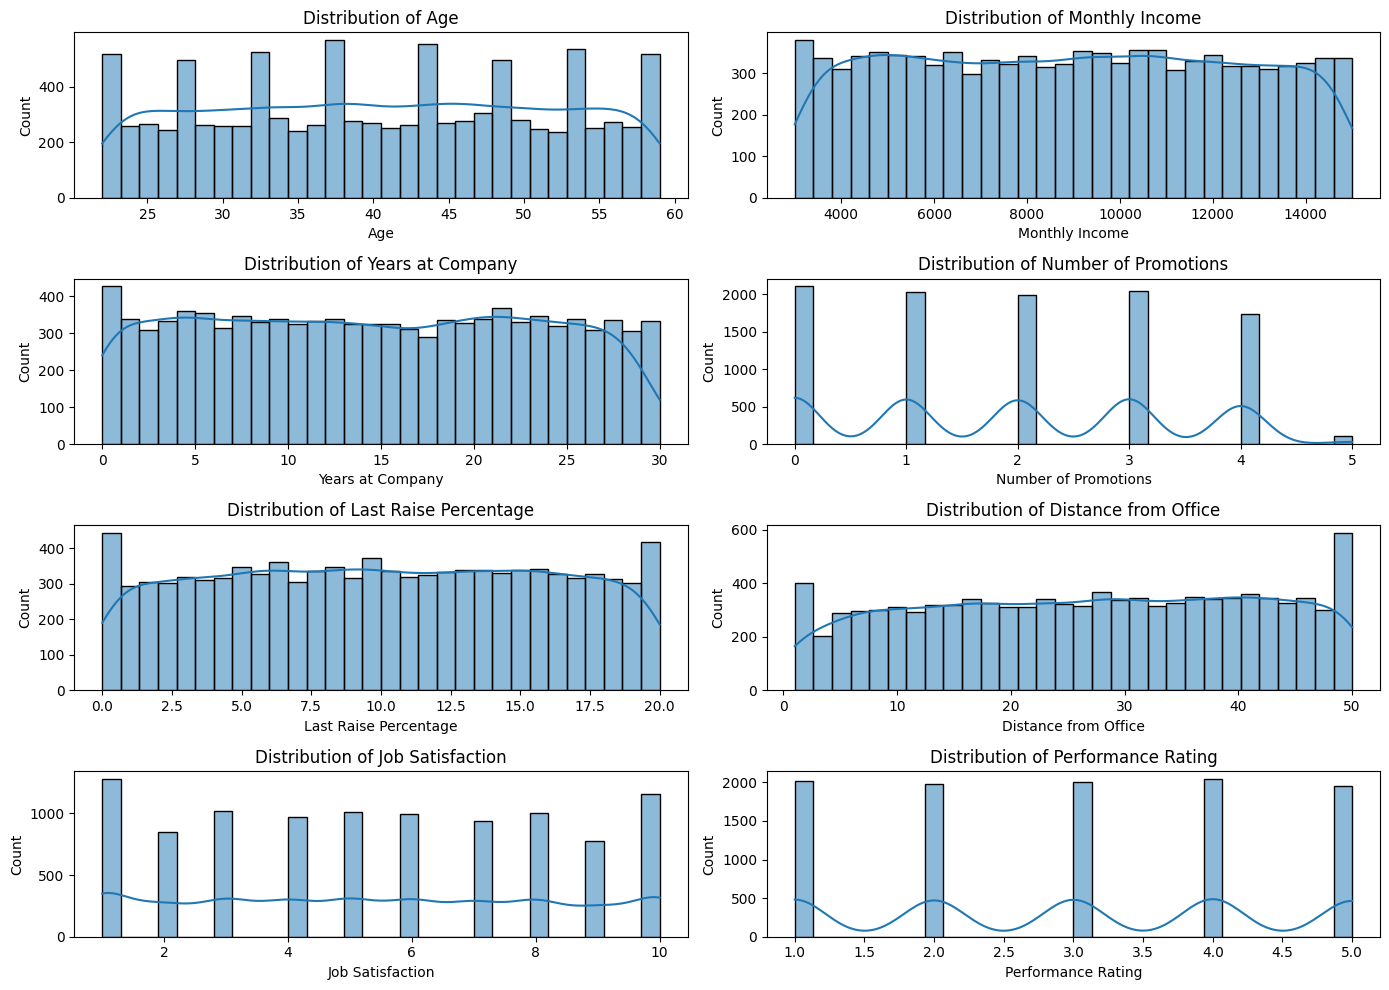

In [69]:
# histogram of num
num_cols = ['Age', 'Monthly Income', 'Years at Company', 'Number of Promotions', 'Last Raise Percentage','Distance from Office','Job Satisfaction','Performance Rating']

plt.figure(figsize=(14, 10))
for i, col in enumerate(num_cols):
    plt.subplot(4, 2, i+1)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


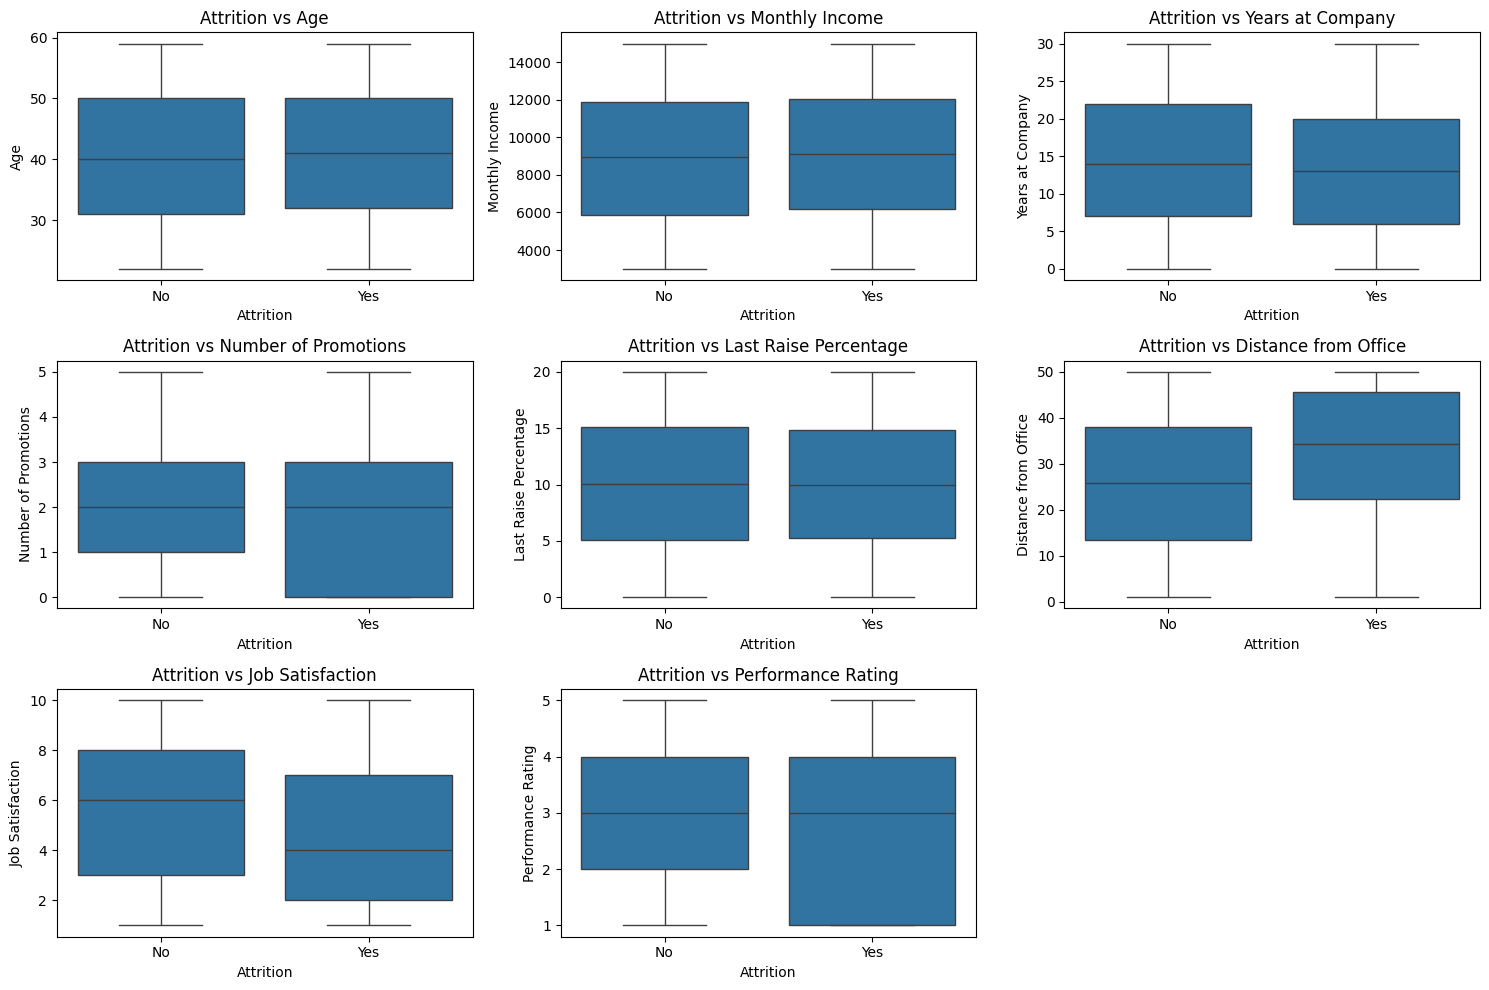

In [70]:
# Load the dataset (if not already loaded)
# df = pd.read_csv('/mnt/data/your_file.csv')

# Create a list of columns to plot against 'Attrition'
columns_to_plot = ['Age', 'Monthly Income', 'Years at Company', 'Number of Promotions', 
                   'Last Raise Percentage', 'Distance from Office', 'Job Satisfaction', 
                   'Performance Rating']

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Loop through the columns and create a box plot for each
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=df, x='Attrition', y=column)
    plt.title(f'Attrition vs {column}')
    plt.tight_layout()

plt.show()

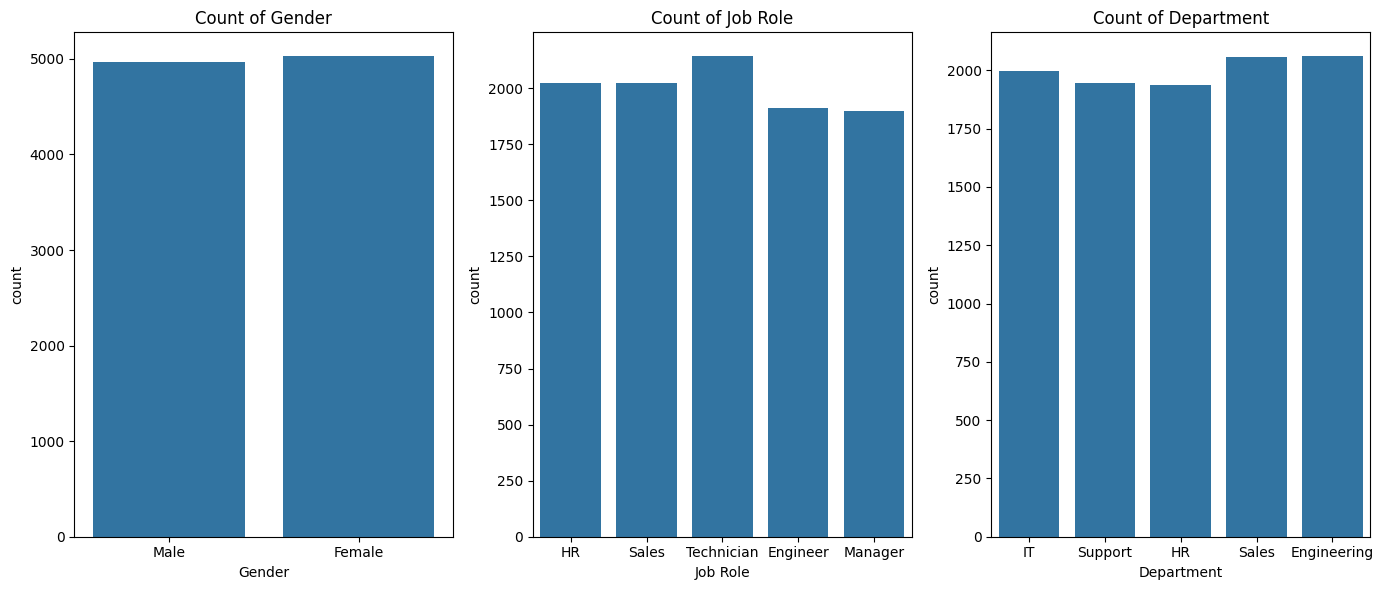

In [71]:
# histogram of cat
cat_cols = ['Gender','Job Role','Department']

plt.figure(figsize=(14, 6))
for i, col in enumerate(cat_cols):
    plt.subplot(1, len(cat_cols), i+1)
    sns.countplot(x=data[col])
    plt.title(f'Count of {col}')
plt.tight_layout()
plt.show()


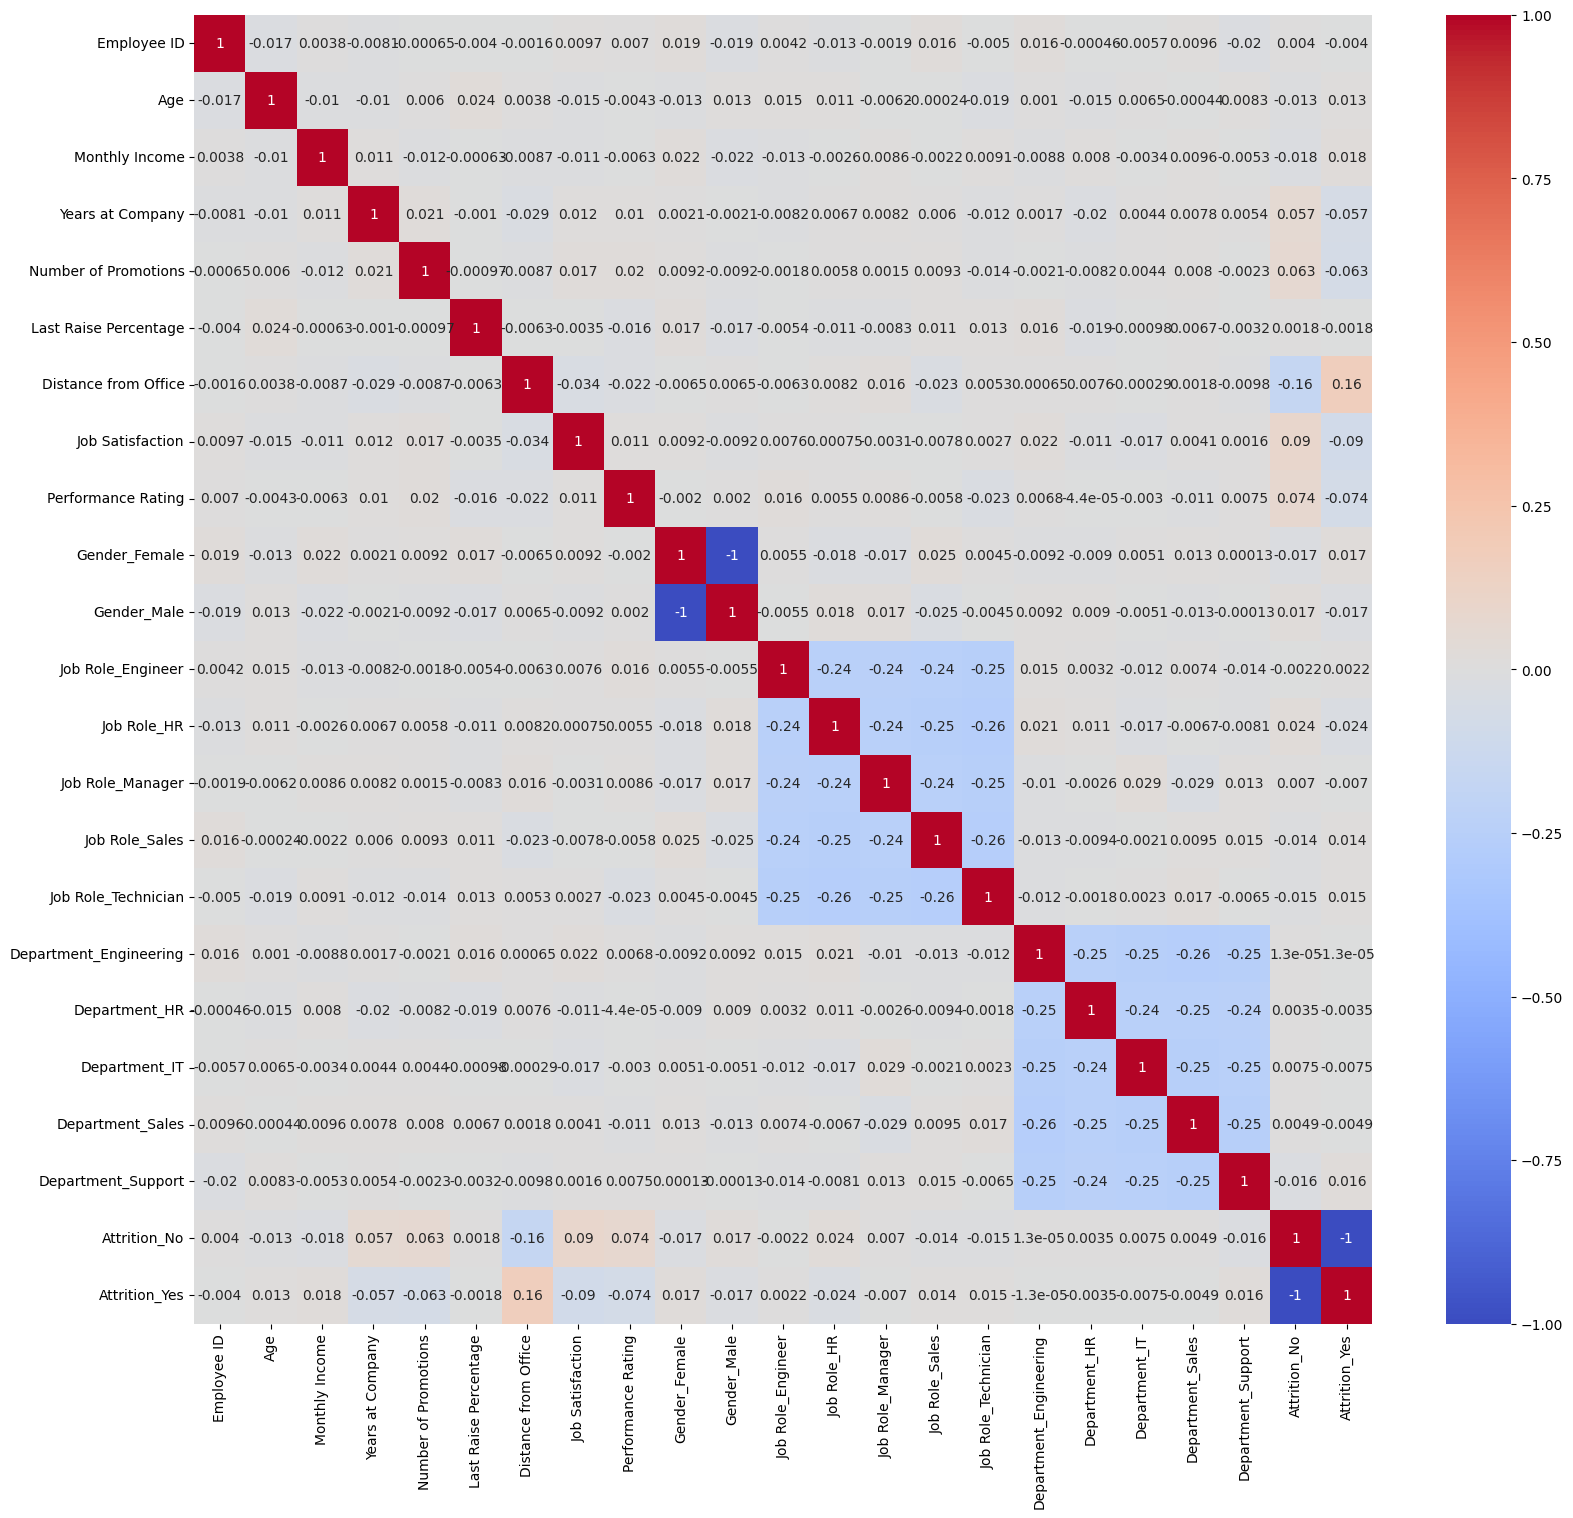

In [72]:
# Convert categorical variables to numeric using one-hot encoding
df_encoded = pd.get_dummies(df)

# Calculate correlation matrix
correlation_matrix = df_encoded.corr()

# Plot the correlation matrix
plt.figure(figsize=(19, 17))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

Insight from heatmap: Distance form office have the most strong relationship from attrition. Also, job satificate and profermance rate also have relation from attrition



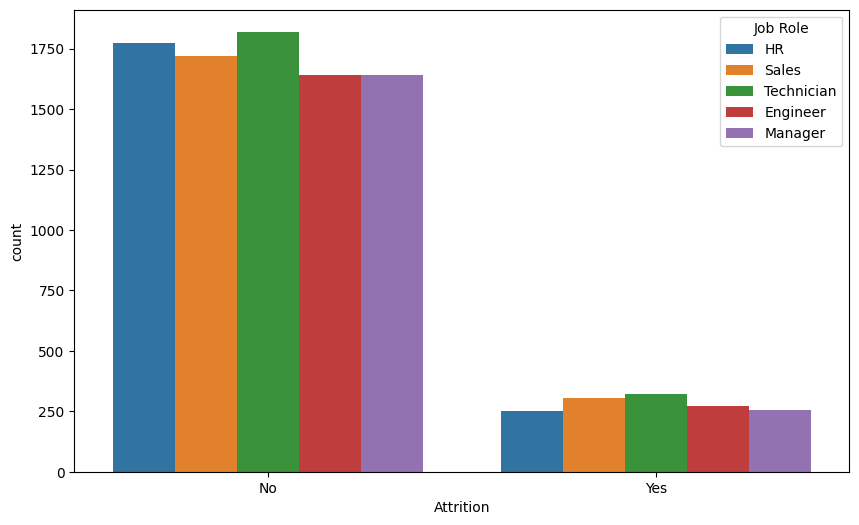

In [73]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Attrition', hue='Job Role', data=df)
plt.show()


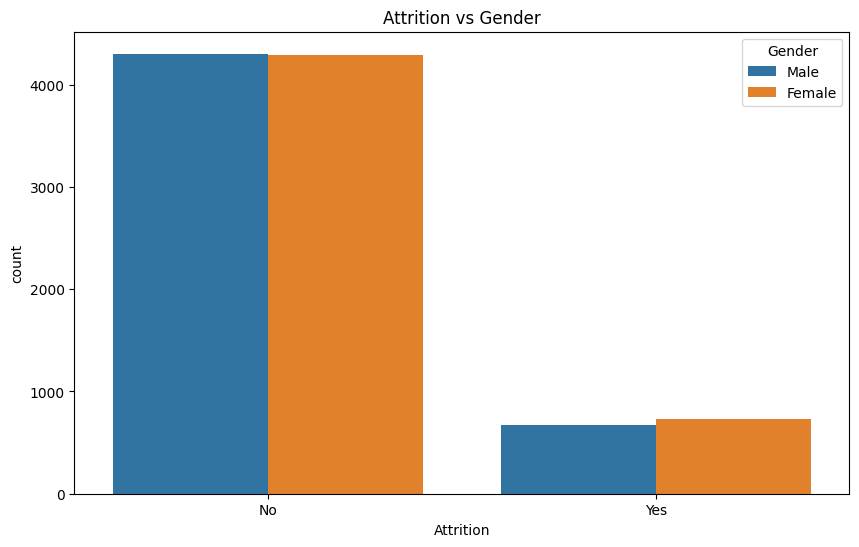

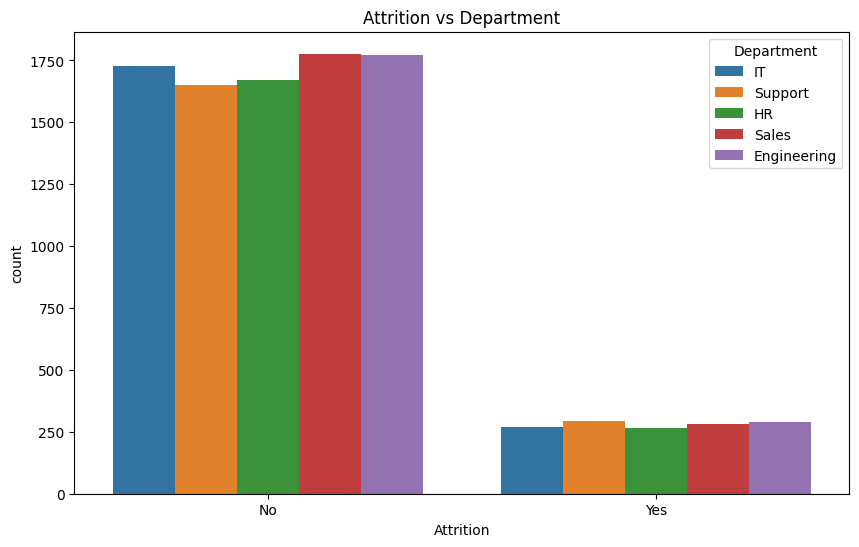

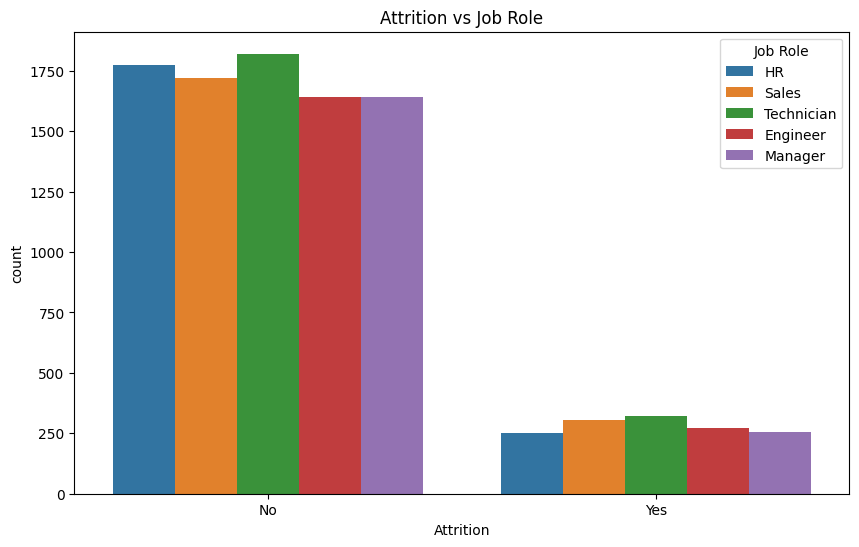

In [74]:
categorical_features = ['Gender', 'Department', 'Job Role']
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Attrition', hue=feature, data=df)
    plt.title(f'Attrition vs {feature}')
    plt.show()


###### Hypothesis: There is a positive correlation between the distance from office and employee turnover rate. employees who are farther away from the company are more likely to resign.

### Feature engeenering


In [75]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply Label Encoding to the Department & Job Role column
df['Department'] = label_encoder.fit_transform(df['Department'])
df['Job Role'] = label_encoder.fit_transform(df['Job Role'])

In [76]:
from sklearn.preprocessing import OneHotEncoder

df = pd.get_dummies(df, columns=['Gender', 'Attrition'], drop_first=True)


In [77]:
# demonstrate what MinMaxScaler() does
MinMaxScaler().fit_transform(df[['Monthly Income', 'Years at Company', 'Number of Promotions','Distance from Office', 'Job Satisfaction', 'Performance Rating']])

array([[0.71230936, 0.4       , 0.2       , 0.82260519, 0.88888889,
        0.        ],
       [0.47028919, 0.93333333, 0.8       , 0.89251436, 0.77777778,
        0.        ],
       [0.78489874, 0.4       , 0.8       , 0.36014033, 0.        ,
        0.5       ],
       ...,
       [0.8084007 , 0.03333333, 0.        , 0.24386757, 0.        ,
        0.        ],
       [0.75114593, 0.7       , 0.6       , 1.        , 0.33333333,
        0.75      ],
       [0.17793149, 0.3       , 0.        , 0.36390293, 0.88888889,
        0.25      ]])

In [78]:
columns = df.columns
print(columns)

Index(['Employee ID', 'Age', 'Job Role', 'Department', 'Monthly Income',
       'Years at Company', 'Number of Promotions', 'Last Raise Percentage',
       'Distance from Office', 'Job Satisfaction', 'Performance Rating',
       'Gender_Male', 'Attrition_Yes'],
      dtype='object')


In [79]:
# split data into X variables and y variable
x=df[['Monthly Income', 'Years at Company', 'Number of Promotions','Distance from Office', 'Job Satisfaction', 'Performance Rating', 'Gender_Male']]
y=df['Attrition_Yes']

In [80]:
# reserve 30% for testing
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42)

In [81]:
numeric_columns = ['Monthly Income', 'Years at Company', 'Number of Promotions','Distance from Office', 'Job Satisfaction', 'Performance Rating', 'Gender_Male']
categorical_columns = ['Attrition_Yes']

In [82]:
df.groupby('Attrition_Yes')['Attrition_Yes'].count()/len(df)

Attrition_Yes
False    0.8597
True     0.1403
Name: Attrition_Yes, dtype: float64

## KNN

In [83]:
knn = KNeighborsClassifier()
#use KNN
knn_scores = cross_val_score(knn, x_train, y_train, scoring='f1', cv=5)


In [147]:
knn_15 = KNeighborsClassifier(n_neighbors=15).fit(x_train,y_train)
pred_15 = knn_15.predict(x_test)
print(accuracy_score(y_test, pred_15))
print(f1_score(y_test, pred_15))
print(precision_score(y_test, pred_15))
print(recall_score(y_test, pred_15))


0.8556666666666667
0.0
0.0
0.0


TypeError: Singleton array array(Ellipsis, dtype=object) cannot be considered a valid collection.

In [85]:
%pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(x_train, y_train)

knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_res, y_train_res)
y_knn_res = knn.predict(x_test)


Note: you may need to restart the kernel to use updated packages.


In [86]:

print(accuracy_score(y_test, y_knn_res))
print(f1_score(y_test, y_knn_res))
print(precision_score(y_test, y_knn_res))
print(recall_score(y_test, y_knn_res))

print(classification_report(y_test, y_knn_res))
print(confusion_matrix(y_test, y_knn_res))

0.568
0.25259515570934254
0.16820276497695852
0.5069444444444444
              precision    recall  f1-score   support

       False       0.87      0.58      0.70      2568
        True       0.17      0.51      0.25       432

    accuracy                           0.57      3000
   macro avg       0.52      0.54      0.47      3000
weighted avg       0.77      0.57      0.63      3000

[[1485 1083]
 [ 213  219]]


## Logistic

In [87]:

logreg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=10000)
logreg_scores = cross_val_score(logreg, x_train, y_train, scoring='f1', cv=5)

In [88]:
logreg.fit(x_train, y_train)
y_pred_logreg = logreg.predict(x_test)


In [89]:
print(accuracy_score(y_test, y_pred_logreg ))
print(f1_score(y_test, y_pred_logreg ))
print(precision_score(y_test, y_pred_logreg ))
print(recall_score(y_test, y_pred_logreg ))

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logreg))

0.612
0.3038277511961722
0.20483870967741935
0.5879629629629629
Logistic Regression Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.62      0.73      2568
        True       0.20      0.59      0.30       432

    accuracy                           0.61      3000
   macro avg       0.55      0.60      0.52      3000
weighted avg       0.80      0.61      0.67      3000



In [90]:
%pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

# handle imbalanced data
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(x_train, y_train)

# train again
log_reg_res = LogisticRegression()
log_reg_res.fit(X_train_res, y_train_res)
y_pred_res = log_reg_res.predict(x_test)


Note: you may need to restart the kernel to use updated packages.


c:\Users\t\AppData\Local\R-MINI~1\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [91]:
print(accuracy_score(y_test, y_pred_res ))
print(f1_score(y_test, y_pred_res ))
print(precision_score(y_test, y_pred_res ))
print(recall_score(y_test, y_pred_res ))

# Assess the performance of the model
print(classification_report(y_test, y_pred_res))
print(confusion_matrix(y_test, y_pred_res))

0.6623333333333333
0.3037800687285223
0.21603128054740958
0.5115740740740741
              precision    recall  f1-score   support

       False       0.89      0.69      0.78      2568
        True       0.22      0.51      0.30       432

    accuracy                           0.66      3000
   macro avg       0.55      0.60      0.54      3000
weighted avg       0.80      0.66      0.71      3000

[[1766  802]
 [ 211  221]]


In [92]:
## improve logistic model

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid_logreg = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300]
}

logreg = LogisticRegression()

# Hyperparameter search
grid_search_logreg = GridSearchCV(logreg, param_grid_logreg, cv=5, scoring='f1')
grid_search_logreg.fit(x_train, y_train)
print(f"Best Logistic Regression Parameters: {grid_search_logreg.best_params_}")


c:\Users\t\AppData\Local\R-MINI~1\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\t\AppData\Local\R-MINI~1\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\t\AppData\Local\R-MINI~1\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\t\AppData\Local\R-MINI~1\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\t\AppData\Local\R-MINI~1\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\t\AppData\Local\R-MINI~1\lib\site-packages\sklearn\linea

Best Logistic Regression Parameters: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


c:\Users\t\AppData\Local\R-MINI~1\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [93]:

# use the parameter 
best_logreg = LogisticRegression(**grid_search_logreg.best_params_)
best_logreg.fit(x_train, y_train)

# assessment Logistic Regression
logreg_best_scores = cross_val_score(best_logreg, x_train, y_train, scoring='f1', cv=5)
print(f"Best Logistic Regression Model F1 Score: {np.mean(logreg_best_scores)}")

# predict
y_pred_best_logreg = best_logreg.predict(x_test)

#Report
logreg_accuracy = accuracy_score(y_test, y_pred_best_logreg)
print(f"Best Logistic Regression Model Accuracy: {logreg_accuracy}")


print("Best Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_logreg))
print("Best Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_best_logreg))

c:\Users\t\AppData\Local\R-MINI~1\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\t\AppData\Local\R-MINI~1\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

Best Logistic Regression Model F1 Score: 0.0395292025468958
Best Logistic Regression Model Accuracy: 0.8553333333333333
Best Logistic Regression Confusion Matrix:
[[2562    6]
 [ 428    4]]
Best Logistic Regression Classification Report:
              precision    recall  f1-score   support

       False       0.86      1.00      0.92      2568
        True       0.40      0.01      0.02       432

    accuracy                           0.86      3000
   macro avg       0.63      0.50      0.47      3000
weighted avg       0.79      0.86      0.79      3000



### Desion Tree

In [125]:
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)


In [126]:
dt.fit(x_train, y_train)
pred_train1 = dt.predict(x_train)
pred_test1 = dt.predict(x_test)

In [127]:

# without constraints we can see the tree is perfectly fitted to the training data
print(accuracy_score(pred_train1, y_train))
print(accuracy_score(pred_test1, y_test))

1.0
0.777


In [128]:
params = {'max_depth':[2,3,4,5,6,7,8]
          , 'min_samples_split': [8,10,15,20],
           'min_samples_leaf': [4, 8, 10, 20]}

In [129]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(dt, params, cv=5,verbose=1, scoring='accuracy')

In [130]:
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 112 candidates, totalling 560 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8],
                         'min_samples_leaf': [4, 8, 10, 20],
                         'min_samples_split': [8, 10, 15, 20]},
             scoring='accuracy', verbose=1)

In [131]:

print(grid_search.best_params_)

{'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 8}


In [134]:
dt = DecisionTreeClassifier(max_depth = 5, min_samples_leaf=8, min_samples_split=8,random_state=123)
dt = dt.fit(x_train, y_train)

pred_train1 = dt.predict(x_train)
pred_test1 = dt.predict(x_test)
print(accuracy_score(pred_train1, y_train))
print(accuracy_score(pred_test1, y_test))

0.8667142857142857
0.8446666666666667


In [135]:
print(accuracy_score(pred_test1, y_test))
print(f1_score(pred_test1, y_test, average='weighted'))
print(precision_score(pred_test1, y_test, average='weighted'))
print(recall_score(pred_test1, y_test, average='weighted'))

print(classification_report(pred_test1, y_test))
print(confusion_matrix(pred_test1, y_test))

0.8446666666666667
0.8911707280553995
0.9494428868120457
0.8446666666666667
              precision    recall  f1-score   support

       False       0.98      0.86      0.91      2912
        True       0.06      0.31      0.10        88

    accuracy                           0.84      3000
   macro avg       0.52      0.58      0.51      3000
weighted avg       0.95      0.84      0.89      3000

[[2507  405]
 [  61   27]]


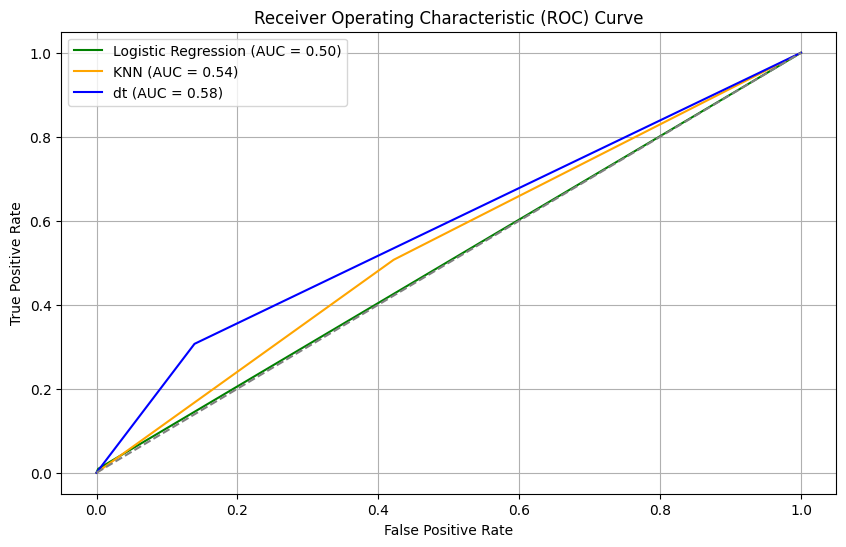

In [139]:
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt

# Calculate ROC curves and AUC scores for each model

fpr_knn, tpr_knn, _ = roc_curve(y_test, y_knn_res)
roc_auc_knn = roc_auc_score(y_test, y_knn_res)

fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_best_logreg)
roc_auc_logreg = roc_auc_score(y_test, y_pred_best_logreg)

fpr, tpr, _ = roc_curve(pred_test1, y_test)
roc_auc = roc_auc_score(pred_test1, y_test)


# Plot ROC curves
plt.figure(figsize=(10, 6))

plt.plot(fpr_logreg, tpr_logreg, color='green', label=f'Logistic Regression (AUC = {roc_auc_logreg:.2f})')
plt.plot(fpr_knn, tpr_knn, color='orange', label=f'KNN (AUC = {roc_auc_knn:.2f})')
plt.plot(fpr, tpr, color='blue', label=f'dt (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()

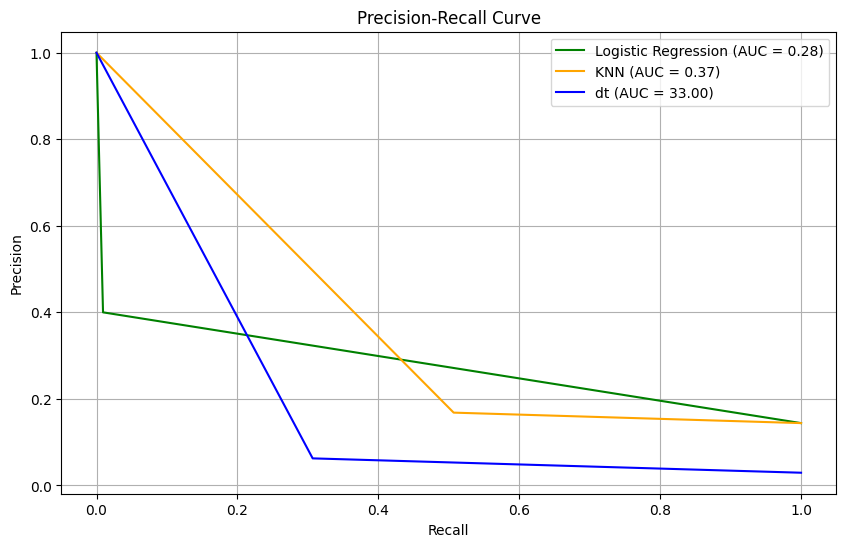

In [140]:
from sklearn.metrics import precision_recall_curve, auc

# 计算PR曲线和AUC分数

precision_knn, recall_knn, _ = precision_recall_curve(y_test,y_knn_res)
pr_auc_knn = auc(recall_knn, precision_knn)

precision_logreg, recall_logreg, _ = precision_recall_curve(y_test, y_pred_best_logreg)
pr_auc_logreg = auc(recall_logreg, precision_logreg)

precision, recall, _ = precision_recall_curve(pred_test1, y_test)
pr_auc_dt = auc(pred_test1, y_test)

# 绘制PR曲线
plt.figure(figsize=(10, 6))

plt.plot(recall_logreg, precision_logreg, color='green', label=f'Logistic Regression (AUC = {pr_auc_logreg:.2f})')
plt.plot(recall_knn, precision_knn, color='orange', label=f'KNN (AUC = {pr_auc_knn:.2f})')
plt.plot(recall,precision, color='blue', label=f'dt (AUC = {pr_auc_dt:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()


### NB

In [142]:
nb = GaussianNB()
nb_scores = cross_val_score(nb, x_train, y_train, scoring='f1', cv=5)

In [143]:
nb.fit(x_train, y_train)
y_pred_nb = nb.predict(x_test)

In [144]:
# Report


print(accuracy_score(y_test, y_pred_nb))
print(f1_score(y_test, y_pred_nb, average='weighted'))
print(precision_score(y_test, y_pred_nb, average='weighted'))
print(recall_score(y_test, y_pred_nb, average='weighted'))

print(classification_report(y_test, y_pred_nb))
print(confusion_matrix(y_test, y_pred_nb))



0.8556666666666667
0.7894205137416921
0.7326948982994331
0.8556666666666667
              precision    recall  f1-score   support

       False       0.86      1.00      0.92      2568
        True       0.00      0.00      0.00       432

    accuracy                           0.86      3000
   macro avg       0.43      0.50      0.46      3000
weighted avg       0.73      0.86      0.79      3000

[[2567    1]
 [ 432    0]]


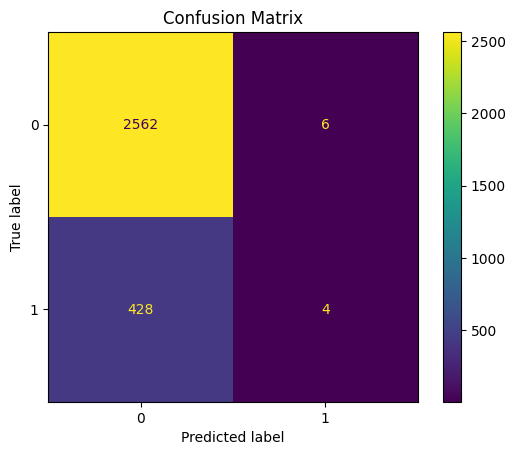

In [153]:
# Plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

conf_matrix = confusion_matrix(y_test, y_pred_best_logreg)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.title('Confusion Matrix')
plt.show()